In [1]:
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras import optimizers
from keras.layers import Dense
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from pandas import ExcelFile
from pandas import ExcelWriter
from PIL import Image
from scipy import ndimage
from scipy.stats import randint as sp_randint
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import datasets
from sklearn import metrics
from sklearn import pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from tensorflow.python.framework import ops
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import pandas as pd
import scipy
import tensorflow as tf
import xlsxwriter

import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model


import keras.backend as K
%load_ext autoreload
%matplotlib inline

Using TensorFlow backend.


In [2]:
from __future__ import print_function
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
 
from matplotlib import pyplot as plt
%matplotlib inline
print("RDKit: %s"%rdkit.__version__)

RDKit: 2019.09.3


RDKit WARNING: [07:05:03] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
import keras
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Input, GlobalMaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
print("Keras: %s"%keras.__version__)

Keras: 2.2.4


In [4]:
data = pd.read_excel(r'IGC50.xlsx')

In [5]:
data["mol"] = data["smiles"].apply(Chem.MolFromSmiles)

In [6]:
def chemcepterize_mol(mol, embed=20.0, res=0.5):
    dims = int(embed*2/res)
    #print(dims)
   
    #print(mol)
    #print(",,,,,,,,,,,,,,,,,,,,,,")
    cmol = Chem.Mol(mol.ToBinary())
    #print(cmol)
    #print(",,,,,,,,,,,,,,,,,,,,,,")
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    #print(coords)
    #print(",,,,,,,,,,,,,,,,,,,,,,")
    vect = np.zeros((dims,dims,4))
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2)) #
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy ,0] = bondorder
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
            vect[ idx , idy, 1] = atom.GetAtomicNum()
            #Gasteiger Charges
            charge = atom.GetProp("_GasteigerCharge")
            vect[ idx , idy, 3] = charge
            #Hybridization
            hyptype = atom.GetHybridization().real
            vect[ idx , idy, 2] = hyptype
            
    return vect

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(100, 100, 4)


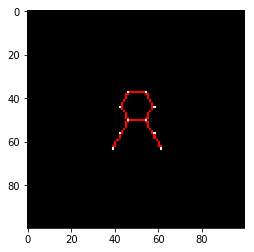

In [7]:
mol = data["mol"][104]
v = chemcepterize_mol(mol, embed=10, res=0.2)

print(v.shape)
plt.imshow(v[:,:,:3])    


In [8]:
def vectorize(mol):
    return chemcepterize_mol(mol, embed=12)
data["molimage"] = data["mol"].apply(vectorize)

In [9]:
X_train = np.array(list(data["molimage"][data["split"]==1]))
X_test = np.array(list(data["molimage"][data["split"]==0]))
print(X_train.shape)
print(X_test.shape)

(1434, 48, 48, 4)
(358, 48, 48, 4)


In [10]:
assay = "Activity"
y_train = data[assay][data["split"]==1].values.reshape(-1,1)
y_test = data[assay][data["split"]==0].values.reshape(-1,1)

In [11]:
print(np.shape(y_train))

(1434, 1)


In [12]:
input_shape = X_train.shape[1:]
print(input_shape)
from keras.layers import Dense, Dropout

(48, 48, 4)


In [13]:
input_img = Input(shape=input_shape)
 
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(input_img)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dense(512, activation='relu', input_shape=input_shape)(x)
#x = Dropout(rate=0.2)(x)
x = Dense(256, activation='relu')(x)
#x = Dropout(rate=0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dense(100, activation='relu')(x)
output = Dense(1, activation='linear')(x)
 
model = Model(inputs=input_img, outputs=output)
 
print(model.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        1184      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        9248      
______________________

In [14]:
from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator(rotation_range=180,
                               width_shift_range=0.1,height_shift_range=0.1,
                               fill_mode="constant",cval = 0,
                               horizontal_flip=True, vertical_flip=True,data_format='channels_last',
                            
                               )


In [15]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [16]:

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr


In [18]:
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [19]:
optimizer = Adam(lr=0.00025)
lr_metric = get_lr_metric(optimizer)
model.compile(loss="mse", optimizer=optimizer, metrics=[coeff_determination, lr_metric ,rmse])

In [20]:
from tensorflow.keras.callbacks import Callback
class NBatchLogger(Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.metric_cache = {}
        
    #def on_train_begin(self, logs=None):
    #    self.epochs = self.params['epochs']    

    def on_epoch_end(self, epoch, logs={}):
        #print('epoch', epoch)
        #print('epoch summary', epoch.summary())
        if int(epoch) % 10 == 0:  # or save after some epoch, each k-th epoch etc.
            #self.model.save("model_{}.hd5".format(epoch))
        #self.step += 1
            for k in self.params['metrics']:
                if k in logs:
                    self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        
            metrics_log = ''
            for (k, v) in self.metric_cache.items():
                val = v / self.display
                if abs(val) > 1e-3:
                    metrics_log += ' - %s: %.4f' % (k, val)
                else:
                    metrics_log += ' - %s: %.4e' % (k, val)
            print('step: {}/{} ... {}'.format(self.step,
                                          self.params['steps'],
                                          metrics_log))
            self.metric_cache.clear()

In [21]:
#Concatenate for longer epochs
Xt = np.concatenate([X_train]*50, axis=0)
yt = np.concatenate([y_train]*50, axis=0)
 
batch_size=128

g = generator.flow(Xt, yt, batch_size=batch_size, shuffle=True)
steps_per_epoch = 10000/batch_size



callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-15, verbose=0, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="weights.best.hdf5", monitor='val_loss', save_best_only=True, verbose=0, mode='auto'),
    NBatchLogger(display=10)
]



history =model.fit_generator(g,
                              steps_per_epoch=len(Xt)//batch_size,
                              epochs=150,
                              validation_data=(X_test,y_test),verbose=1)
                              #callbacks=callbacks_list)




Epoch 1/150





560/560 [==============================] - 63s 112ms/step - loss: 1.0454 - coeff_determination: 0.0695 - lr: 2.5000e-04 - rmse: 0.9330 - val_loss: 0.5449 - val_coeff_determination: 0.4380 - val_lr: 2.5000e-04 - val_rmse: 0.7344
Epoch 2/150
560/560 [==============================] - 60s 108ms/step - loss: 0.6298 - coeff_determination: 0.4397 - lr: 2.5000e-04 - rmse: 0.7915 - val_loss: 0.6028 - val_coeff_determination: 0.3751 - val_lr: 2.5000e-04 - val_rmse: 0.7740
Epoch 3/150
560/560 [==============================] - 61s 109ms/step - loss: 0.6113 - coeff_determination: 0.4558 - lr: 2.5000e-04 - rmse: 0.7799 - val_loss: 0.7244 - val_coeff_determination: 0.2460 - val_lr: 2.5000e-04 - val_rmse: 0.8494
Epoch 4/150
560/560 [==============================] - 60s 108ms/step - loss: 0.5953 - coeff_determination: 0.4697 - lr: 2.5000e-04 - rmse: 0.7695 - val_loss: 0.8739 - val_coeff_determination: 0.0865 - val_lr: 2.5000e-04 - val_rmse: 0.9339
Epoch 5/150
560/560 [===========

560/560 [==============================] - 60s 108ms/step - loss: 0.2550 - coeff_determination: 0.7715 - lr: 2.5000e-04 - rmse: 0.5031 - val_loss: 0.5405 - val_coeff_determination: 0.4421 - val_lr: 2.5000e-04 - val_rmse: 0.7316
Epoch 28/150
560/560 [==============================] - 60s 108ms/step - loss: 0.2422 - coeff_determination: 0.7840 - lr: 2.5000e-04 - rmse: 0.4903 - val_loss: 0.7181 - val_coeff_determination: 0.2524 - val_lr: 2.5000e-04 - val_rmse: 0.8457
Epoch 29/150
560/560 [==============================] - 60s 108ms/step - loss: 0.2372 - coeff_determination: 0.7879 - lr: 2.5000e-04 - rmse: 0.4850 - val_loss: 0.4963 - val_coeff_determination: 0.4882 - val_lr: 2.5000e-04 - val_rmse: 0.7011
Epoch 30/150
560/560 [==============================] - 61s 108ms/step - loss: 0.2262 - coeff_determination: 0.7977 - lr: 2.5000e-04 - rmse: 0.4735 - val_loss: 0.5660 - val_coeff_determination: 0.4164 - val_lr: 2.5000e-04 - val_rmse: 0.7486
Epoch 31/150
560/560 [===========================

560/560 [==============================] - 60s 108ms/step - loss: 0.0726 - coeff_determination: 0.9350 - lr: 2.5000e-04 - rmse: 0.2681 - val_loss: 0.4146 - val_coeff_determination: 0.5740 - val_lr: 2.5000e-04 - val_rmse: 0.6398
Epoch 62/150
560/560 [==============================] - 61s 108ms/step - loss: 0.0706 - coeff_determination: 0.9368 - lr: 2.5000e-04 - rmse: 0.2644 - val_loss: 0.3370 - val_coeff_determination: 0.6563 - val_lr: 2.5000e-04 - val_rmse: 0.5749
Epoch 63/150
560/560 [==============================] - 61s 108ms/step - loss: 0.0666 - coeff_determination: 0.9403 - lr: 2.5000e-04 - rmse: 0.2569 - val_loss: 0.3477 - val_coeff_determination: 0.6447 - val_lr: 2.5000e-04 - val_rmse: 0.5845
Epoch 64/150
560/560 [==============================] - 60s 108ms/step - loss: 0.0641 - coeff_determination: 0.9424 - lr: 2.5000e-04 - rmse: 0.2520 - val_loss: 0.3351 - val_coeff_determination: 0.6589 - val_lr: 2.5000e-04 - val_rmse: 0.5723
Epoch 65/150
560/560 [===========================

560/560 [==============================] - 60s 107ms/step - loss: 0.0261 - coeff_determination: 0.9766 - lr: 2.5000e-04 - rmse: 0.1601 - val_loss: 0.2907 - val_coeff_determination: 0.7064 - val_lr: 2.5000e-04 - val_rmse: 0.5302
Epoch 96/150
560/560 [==============================] - 61s 108ms/step - loss: 0.0243 - coeff_determination: 0.9783 - lr: 2.5000e-04 - rmse: 0.1546 - val_loss: 0.2998 - val_coeff_determination: 0.6981 - val_lr: 2.5000e-04 - val_rmse: 0.5371
Epoch 97/150
560/560 [==============================] - 60s 107ms/step - loss: 0.0253 - coeff_determination: 0.9774 - lr: 2.5000e-04 - rmse: 0.1576 - val_loss: 0.3002 - val_coeff_determination: 0.6986 - val_lr: 2.5000e-04 - val_rmse: 0.5355
Epoch 98/150
560/560 [==============================] - 60s 108ms/step - loss: 0.0247 - coeff_determination: 0.9779 - lr: 2.5000e-04 - rmse: 0.1560 - val_loss: 0.3070 - val_coeff_determination: 0.6890 - val_lr: 2.5000e-04 - val_rmse: 0.5461
Epoch 99/150
560/560 [===========================

Epoch 129/150
560/560 [==============================] - 60s 108ms/step - loss: 0.0132 - coeff_determination: 0.9882 - lr: 2.5000e-04 - rmse: 0.1135 - val_loss: 0.2906 - val_coeff_determination: 0.7080 - val_lr: 2.5000e-04 - val_rmse: 0.5281
Epoch 130/150
560/560 [==============================] - 60s 108ms/step - loss: 0.0139 - coeff_determination: 0.9877 - lr: 2.5000e-04 - rmse: 0.1166 - val_loss: 0.2713 - val_coeff_determination: 0.7296 - val_lr: 2.5000e-04 - val_rmse: 0.5072
Epoch 131/150
560/560 [==============================] - 60s 108ms/step - loss: 0.0173 - coeff_determination: 0.9843 - lr: 2.5000e-04 - rmse: 0.1274 - val_loss: 0.2844 - val_coeff_determination: 0.7165 - val_lr: 2.5000e-04 - val_rmse: 0.5188
Epoch 132/150
560/560 [==============================] - 60s 107ms/step - loss: 0.0150 - coeff_determination: 0.9866 - lr: 2.5000e-04 - rmse: 0.1201 - val_loss: 0.2906 - val_coeff_determination: 0.7047 - val_lr: 2.5000e-04 - val_rmse: 0.5313
Epoch 133/150
560/560 [=========

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
No handles with labels found to put in legend.
No handles with labels found to put in legend.


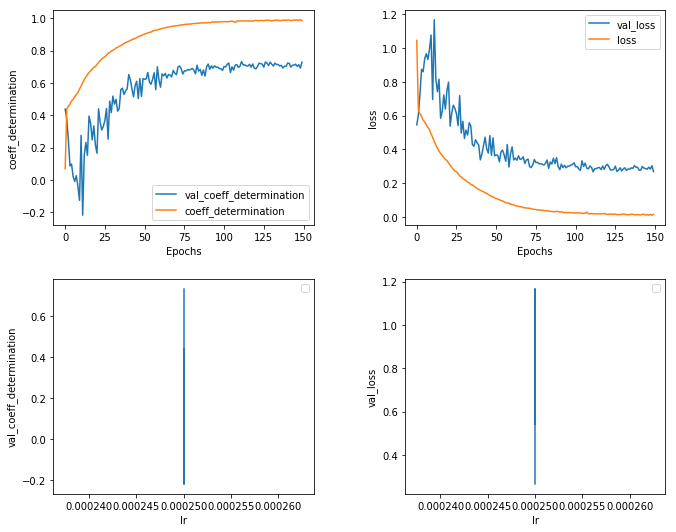

In [22]:
hist = history.history

plt.figure(figsize=(10, 8))

for label in ['val_coeff_determination','coeff_determination']:
    plt.subplot(221)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("coeff_determination")
    
for label in ['val_loss','loss']:
    plt.subplot(222)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("loss")



plt.subplot(223)
plt.plot( hist['lr'],hist['val_coeff_determination']  )
plt.legend()
plt.xlabel("lr")
plt.ylabel("val_coeff_determination")


plt.subplot(224)
plt.plot( hist['lr'],hist['val_loss']  )
plt.legend()
plt.xlabel("lr")
plt.ylabel("val_loss")

    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)